# Predict_Future_Sales
  
# 1. EDA & Visualizing
## 1.1 Data 구성
__ID__ : test set에서 (Shop, Item) 묶음을 인덱싱  
__shop_id__ : 가게 번호
__item_id__ : 제품 번호  
__item_category_id__ : 제품 카테고리 번호  
__item_cnt_day__ : 판매량  
__item_price__ : 제품 가격  
__date__ : date dd/mm/yyy  
__date_block_num__ : 시간별 월 인덱싱 Jan.2013 = 0 ~ Oct.2015 = 33  
__item_name__ : 제품 이름  
__shop_name__ : 가게 이름  
__item_category_name__ : 제품 카테고리 이름

## 1.2 환경설정

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import random
from utils import *

import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf

import lightgbm
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

import gc
import warnings
from itertools import product
warnings.filterwarnings("ignore")

## 1.2 Data load

In [2]:
file_path = os.getenv('HOME') + '/aiffel/kaggle_future_sales/data/'

df_items = pd.read_csv(file_path + 'items.csv')
df_shops = pd.read_csv(file_path + 'shops.csv')
df_categories = pd.read_csv(file_path + 'item_categories.csv')
df_train = pd.read_csv(file_path + 'sales_train.csv')
df_test = pd.read_csv(file_path + 'test.csv')

### Row Data 열어보기
데이터들의 columns는 어떻게 구성되어 있는지 확인하고  
데이터들간의 연결관계를 파악한다.

In [3]:
df_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [4]:
df_shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [5]:
df_items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [6]:
df_categories.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


train 데이터에 전반적인 정보들이 담겨있다.  
shop, item 데이터에는 상점과 제품의 이름이 담겨있다.  
categories 데이터에는 제품의 카테고리 이름과 아이템 카테고리 id가 있다.  
칵 feature 들의 이름과 id가 연결되어있는 것을 알 수 있다.

### 연결고리 feature들을 이용하여 데이터 merge하기

In [7]:
df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')

df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')

# del df_items, df_categories, df_shops

gc.collect()

0

In [8]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [9]:
df_test.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
2,15,5,4872,"Minecraft. Playstation 3 Edition [PS3, русская...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
3,21,5,5002,"NBA 2K16 [PS3, русская документация]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
4,23,5,5814,"Plants vs. Zombies Garden Warfare [PS3, русска...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""


## 1.3 데이터 정보 열어보기
전체 데이터의 개수 : 2935849  
전체 데이터의 feature 수 : 10  
  
feature 별 가장 많이 존재하는 5가지 데이터  
출력해보았다.

In [10]:
knowningData(df_train)

Dataset Shape: (2935849, 10)
Unique values per column: 
date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19993
item_cnt_day            198
item_name             21807
item_category_id         84
item_category_name       84
shop_name                60
dtype: int64
################

Column Name:  date
entropy  9.91  | Total nulls:  0.0  | Total unique values:  1034  | Missing:  0
Top 5 most frequent values: 
28.12.2013    0.32
29.12.2013    0.32
30.12.2014    0.32
30.12.2013    0.31
31.12.2014    0.28
Name: date, dtype: float64

####################################
Column Name:  date_block_num
entropy  5.04  | Total nulls:  0.0  | Total unique values:  34  | Missing:  0
Top 5 most frequent values: 
11    4.88
23    4.45
2     4.13
0     3.94
1     3.70
Name: date_block_num, dtype: float64

####################################
Column Name:  shop_id
entropy  5.39  | Total nulls:  0.0  | Total unique values

## 1.4 러시아어 번역하기
아이템 카테고리 이름과 가게 이름을 영어로 번역하여 새로운 컬럼으로 주었다.

In [11]:
df_train.item_category_name = df_train.item_category_name.map(dict(zip(df_train.item_category_name.value_counts().index, dict_categories)))
df_train.shop_name = df_train.shop_name.map(dict(zip(df_train.shop_name.value_counts().index, dict_shops)))

In [13]:
df_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl shopping center ""Altair"""


## 1.5 Target data Exploring
타겟데이터인 item_cnt_day를 알아보자.  
정확하게는 item_cnt_day들이 각 가게의 제품별로 한달치가 더 해진  
새로운 정보가 진짜 우리가 예측해야할 타겟이 된다.

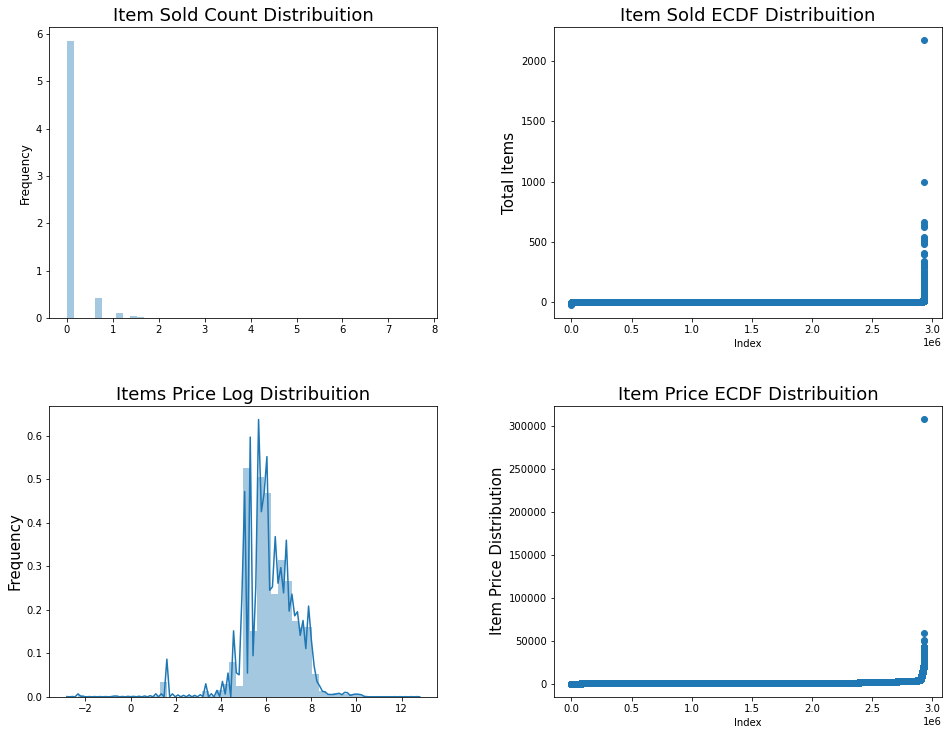

In [14]:
plt.figure(figsize=(16,12))

plt.subplot(221)
g = sns.distplot(np.log(df_train[df_train['item_cnt_day'] >0]['item_cnt_day']))
g.set_title("Item Sold Count Distribuition", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
g1 = plt.scatter(range(df_train.shape[0]), np.sort(df_train.item_cnt_day.values))
g1= plt.title("Item Sold ECDF Distribuition", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Total Items", fontsize=15)

plt.subplot(223)
g2 = sns.distplot(np.log(df_train[df_train['item_price'] > 0]['item_price']))
g2.set_title("Items Price Log Distribuition", fontsize=18)
g2.set_xlabel("")
g2.set_ylabel("Frequency", fontsize=15)

plt.subplot(224)
g3 = plt.scatter(range(df_train.shape[0]), np.sort(df_train.item_price.values))
g3= plt.title("Item Price ECDF Distribuition", fontsize=18)
g3 = plt.xlabel("Index")
g3 = plt.ylabel("Item Price Distribution", fontsize=15)

plt.subplots_adjust(wspace = 0.3, hspace = 0.3,
                    top = 0.9)

plt.show()

전체 우리가 가지고 있는 example들의 판매량과 제품 가격에 대한 분포이다.  
이때 example은 특정 날 특정 가게에서 특정 제품을 의미한다.  
  
판매량이 0인 날이 대부분이고, 제품 가격대의 분포가 다양해보인다.  
심지어 가격대가 0 이하로 추정되는 데이터가 있음을 알 수 있다.  
  
outlier가 보이는 것 같은데 무작정 지우기 보다는 좀 더 알아볼 필요가 있어 보인다.

## 1.6 Shop, category 그리고 items columns 알아보기
가장 많이 등장하는 탑 20 shop 시각화  
가게들이 독점적이지 않고 비교적 고르게 등장하는 것을 알 수 있다.

Description most frequent countrys: 
Moscow Shopping Center "Semenovskiy"    235636
Moscow TRK "Atrium"                     186104
Khimki Shopping Center                  143480
Moscow TC "MEGA Teply Stan" II          142234
Yakutsk Ordzhonikidze, 56               117428
St. Petersburg TC "Nevsky Center"       109253
Moscow TC "MEGA Belaya Dacha II"        105366
Voronezh (Plekhanovskaya, 13)            82663
Yakutsk Shopping Center "Central"        71441
Chekhov SEC "Carnival"                   69573
Name: shop_name, dtype: int64


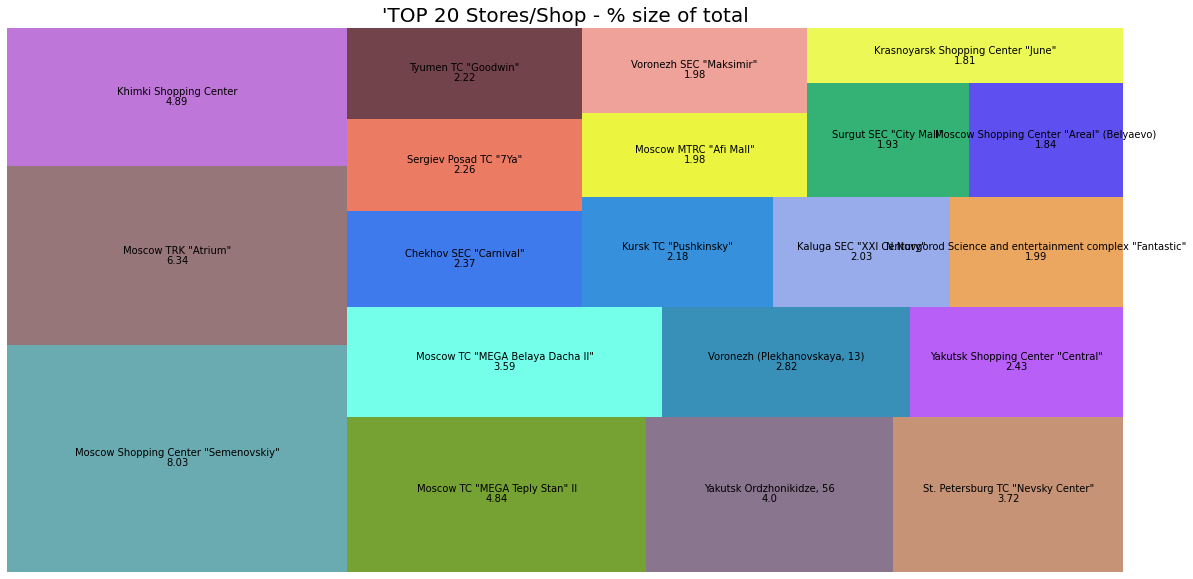

In [18]:
import squarify

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(30)]
shop_name = df_train["shop_name"].value_counts() #counting the values of shop names

print("Description most frequent countrys: ")
print(shop_name[:10]) #printing the 15 top most 

shop = round((df_train["shop_name"].value_counts()[:20] \
                       / len(df_train["shop_name"]) * 100),2)

plt.figure(figsize=(20,10))
g = squarify.plot(sizes=shop.values, label=shop.index, 
                  value=shop.values,
                  alpha=.8, color=color)
g.set_title("'TOP 20 Stores/Shop - % size of total",fontsize=20)
g.set_axis_off()
plt.show()

## 1.7 Shop 별 총 매출

In [19]:
print("Percentual of total sold by each Shop")
print((df_train.groupby('shop_name')['item_price'].sum().nlargest(25) / df_train.groupby('shop_name')['item_price'].sum().sum() * 100)[:5])

df_train.groupby('shop_name')['item_price'].sum().nlargest(25).iplot(kind='bar',
                                                                     title='TOP 25 Shop Name by Total Amount Sold',
                                                                     xTitle='Shop Names', 
                                                                     yTitle='Total Sold')

Percentual of total sold by each Shop
shop_name
Moscow Shopping Center "Semenovskiy"    6.529125
Moscow TRK "Atrium"                     5.947730
Moscow TC "MEGA Teply Stan" II          4.790632
Khimki Shopping Center                  4.193201
Moscow TC "MEGA Belaya Dacha II"        4.039476
Name: item_price, dtype: float64


상위 25개 shop 들의 총 매출을 볼 수 있다.

## 1.8 상점 별 총 판매량

In [20]:
print("Percentual of total sold by each Shop")
print((df_train.groupby('shop_name')['item_cnt_day'].sum().nlargest(25) / df_train.groupby('shop_name')['item_cnt_day'].sum().sum() * 100)[:5])

df_train.groupby('shop_name')['item_cnt_day'].sum().nlargest(25).iplot(kind='bar',
                                                                       title='TOP 25 Shop Name by Total Amount Sold',
                                                                       xTitle='Shop Names', 
                                                                       yTitle='Total Sold')

Percentual of total sold by each Shop
shop_name
Moscow Shopping Center "Semenovskiy"    8.518625
Moscow TRK "Atrium"                     6.631204
Khimki Shopping Center                  5.092640
Moscow TC "MEGA Teply Stan" II          5.058843
St. Petersburg TC "Nevsky Center"       3.972747
Name: item_cnt_day, dtype: float64


## 1.9 로그변환

In [21]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name'],
      dtype='object')

In [23]:
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day']

In [24]:
df_train = log_transforms(df_train, ['item_price', 'item_cnt_day', 'total_amount'])

In [25]:
df_train[['item_cnt_day', 'item_price', 'item_name']].sort_values('item_cnt_day', ascending=False).head(20)

,item_cnt_day,item_price,item_name
2694327,2169.0,0.908714,Доставка до пункта выдачи (Boxberry)
2693208,1000.0,4.000000,Фирменный пакет майка 1С Интерес белый (34*42)...
2698367,669.0,1692.526158,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [..."
2933626,637.0,1702.825746,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У..."
2676429,624.0,1904.548077,"Grand Theft Auto V [PC, русские субтитры]"
2694220,539.0,155.192950,Доставка до пункта выдачи (Boxberry)
2933608,533.0,1500.000000,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У..."
2697330,512.0,1500.000000,"Билет ""ИгроМир 2014"" (на один день (отдельно -..."
2917997,508.0,899.000000,"Средиземье: Тени Мордора [PC, Цифровая версия]"
2698368,504.0,1500.000000,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [..."


## 1.10 아이템 카테고리

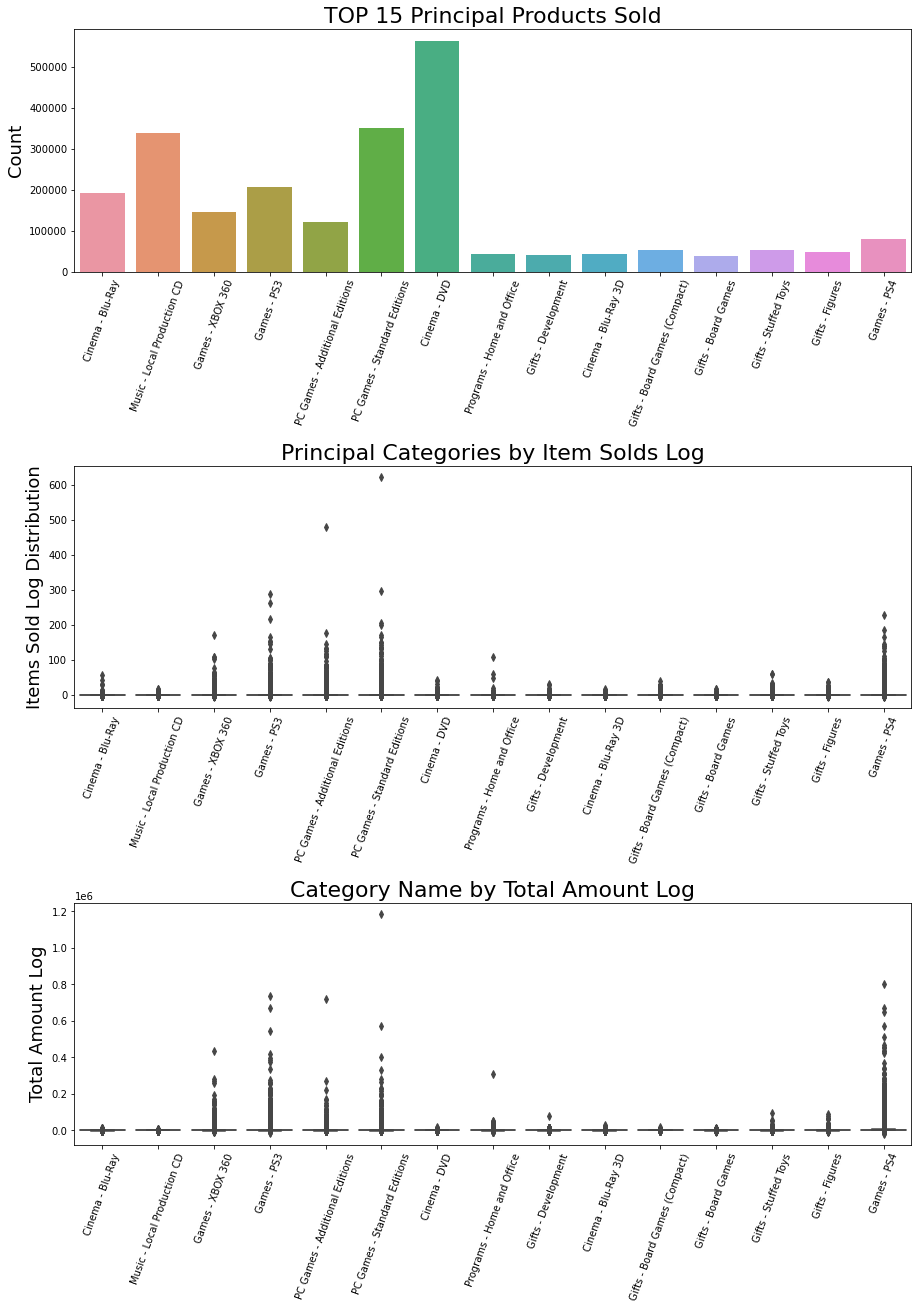

In [26]:
top_cats = df_train.item_category_name.value_counts()[:15]

plt.figure(figsize=(15,20))

plt.subplot(311)
g1 = sns.countplot(x='item_category_name', 
                   data=df_train[df_train.item_category_name.isin(top_cats.index)])
g1.set_xticklabels(g1.get_xticklabels(),rotation=70)
g1.set_title("TOP 15 Principal Products Sold", fontsize=22)
g1.set_xlabel("")
g1.set_ylabel("Count", fontsize=18)

plt.subplot(312)
g2 = sns.boxplot(x='item_category_name', y='item_cnt_day', 
                   data=df_train[df_train.item_category_name.isin(top_cats.index)])
g2.set_xticklabels(g2.get_xticklabels(),rotation=70)
g2.set_title("Principal Categories by Item Solds Log", fontsize=22)
g2.set_xlabel("")
g2.set_ylabel("Items Sold Log Distribution", fontsize=18)

plt.subplot(313)
g3 = sns.boxplot(x='item_category_name', y='total_amount', 
                   data=df_train[df_train.item_category_name.isin(top_cats.index)])
g3.set_xticklabels(g3.get_xticklabels(),rotation=70)
g3.set_title("Category Name by Total Amount Log", fontsize=22)
g3.set_xlabel("")
g3.set_ylabel("Total Amount Log", fontsize=18)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

판매량 상위 15개 제품들의 판매량, 매출 분포이다.

## 1.11 총 매출 상위 5K 아이템

In [27]:
sub_categorys_5000 = df_train.sort_values('total_amount',
                                          ascending=False)[['item_category_name', 'item_name', 
                                                            'shop_name',
                                                            'item_cnt_day','item_price',
                                                            'total_amount']].head(5000)
sub_categorys_5000.head(10)

,item_category_name,item_name,shop_name,item_cnt_day,item_price,total_amount
1068934,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"St. Petersburg TC ""Nevsky Center""",101.0,18118.712871,1.829990e+06
815919,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Moscow Shopping Center ""Semenovskiy""",90.0,18245.555556,1.642100e+06
378795,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Moscow TRK ""Atrium""",85.0,18190.000000,1.546150e+06
2695457,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,Online store of emergencies,84.0,18073.690476,1.518190e+06
2119997,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Krasnoyarsk Shopping Center ""June""",73.0,18305.068493,1.336270e+06
2695470,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,Online store of emergencies,52.0,24278.461538,1.262480e+06
465999,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Voronezh (Plekhanovskaya, 13)",67.0,18198.955224,1.219330e+06
2682591,PC Games - Collectible Editions,Ведьмак 3: Дикая охота. Коллекционное издание ...,Online store of emergencies,140.0,8499.000000,1.189860e+06
2676429,PC Games - Standard Editions,"Grand Theft Auto V [PC, русские субтитры]",Online store of emergencies,624.0,1904.548077,1.188438e+06
2698367,Service Tools - Tickets,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",Online store of emergencies,669.0,1692.526158,1.132300e+06


총매출액이 가장 높은 제품이 PS4인 것을 알 수 있다.

### 매출액 top 5k의 describe를 찍어보자

In [28]:
sub_categorys_5000.describe(include='all')

,item_category_name,item_name,shop_name,item_cnt_day,item_price,total_amount
count,5000,5000,5000,5000.000000,5000.000000,5.000000e+03
unique,35,321,54,NaN,NaN,NaN
top,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Moscow TRK ""Atrium""",NaN,NaN,NaN
freq,1988,1460,383,NaN,NaN,NaN
mean,NaN,NaN,NaN,17.900400,12833.009561,7.686763e+04
std,NaN,NaN,NaN,36.256439,11246.963467,1.043254e+05
min,NaN,NaN,NaN,1.000000,155.192950,3.020150e+04
25%,NaN,NaN,NaN,2.000000,2753.370629,3.789975e+04
50%,NaN,NaN,NaN,8.000000,10490.000000,4.798400e+04
75%,NaN,NaN,NaN,20.000000,22490.000000,7.296000e+04


## 1.12 가장 비싼 거래가 있었던 상점과 제품

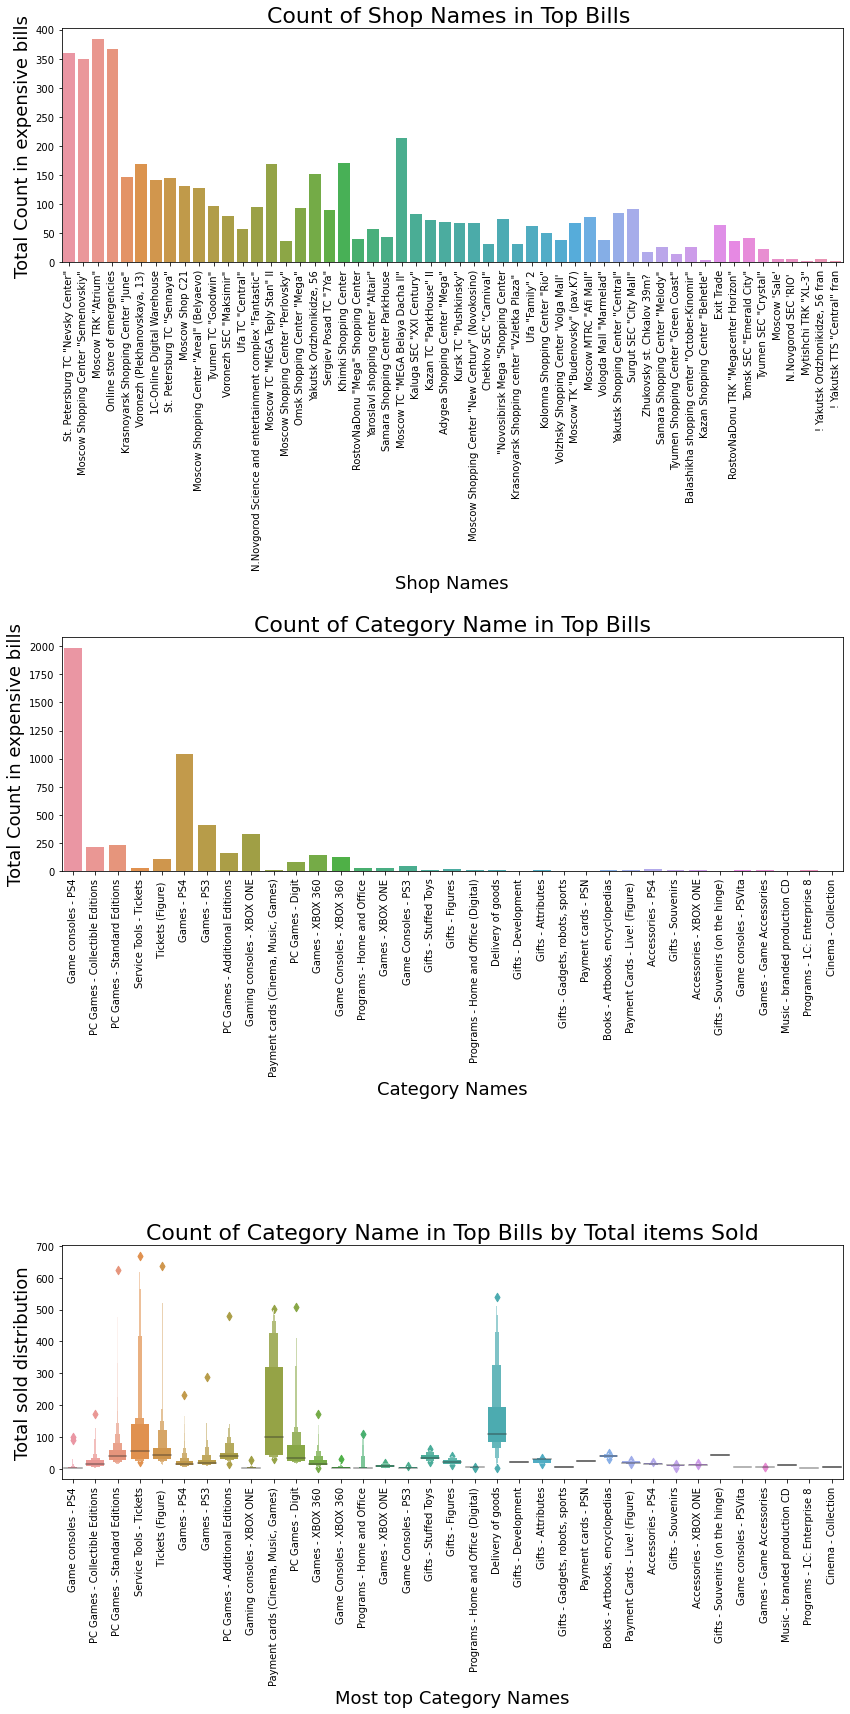

In [29]:
plt.figure(figsize=(14,26))

plt.subplot(311)
g = sns.countplot(x='shop_name', data=sub_categorys_5000)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Shop Names in Top Bills ", fontsize=22)
g.set_xlabel('Shop Names', fontsize=18)
g.set_ylabel("Total Count in expensive bills", fontsize=18)

plt.subplot(312)
g = sns.countplot(x='item_category_name', data=sub_categorys_5000)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Category Name in Top Bills", fontsize=22)
g.set_xlabel('Category Names', fontsize=18)
g.set_ylabel("Total Count in expensive bills", fontsize=18)

plt.subplot(313)
g = sns.boxenplot(x='item_category_name', y='item_cnt_day', data=sub_categorys_5000)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Category Name in Top Bills by Total items Sold", fontsize=22)
g.set_xlabel('Most top Category Names', fontsize=18)
g.set_ylabel("Total sold distribution", fontsize=18)

plt.subplots_adjust(wspace = 0.2, hspace = 1.6,top = 0.9)

plt.show()

총매출 상위 5K에서의 최다 매출 제품들이 판매된 횟수를 살펴보면  
몇몇 값들은 1번만 거래된 것으로 보인다.

### 가장 비싼 제품

In [30]:
df_train[['item_category_name', 'item_name', 'shop_name', 'item_cnt_day', 'item_price']].nlargest(15, 'item_price')

,item_category_name,item_name,shop_name,item_cnt_day,item_price
2678303,Programs - Home and Office,Radmin 3 - 522 лиц.,Online store of emergencies,1.0,307980.0
2693298,Delivery of goods,Доставка (EMS),Online store of emergencies,1.0,59200.0
355222,Gifts - Souvenirs,Коллекционные шахматы (Властелин Колец),"Moscow TRK ""Atrium""",1.0,50999.0
2678339,Programs - Home and Office,UserGate Proxy & Firewall 6.X с модулем фильтр...,Online store of emergencies,1.0,49782.0
1073299,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...","St. Petersburg TC ""Nevsky Center""",1.0,42990.0
2005340,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",Moscow Shop C21,1.0,42990.0
2642052,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...","Balashikha shopping center ""October-Kinomir""",1.0,42990.0
2697533,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",Online store of emergencies,1.0,42990.0
2678292,Programs - Home and Office,UserGate Proxy & Firewall 6.X до 100 сессий,Online store of emergencies,1.0,42000.0
1120510,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...","Omsk Shopping Center ""Mega""",1.0,41990.0


#### 가장 비싼 제품과 그 다음 제품 사이에 차이가 매우 큰 것을 볼 수 있다.

In [32]:
print(f"단 한번 거래된 제품의 비율: {round(len(df_train[df_train.item_cnt_day == 1]) / len(df_train) * 100,2)}%")

단 한번 거래된 제품의 비율: 89.56%


## 1.13 판매량 Top 25 item

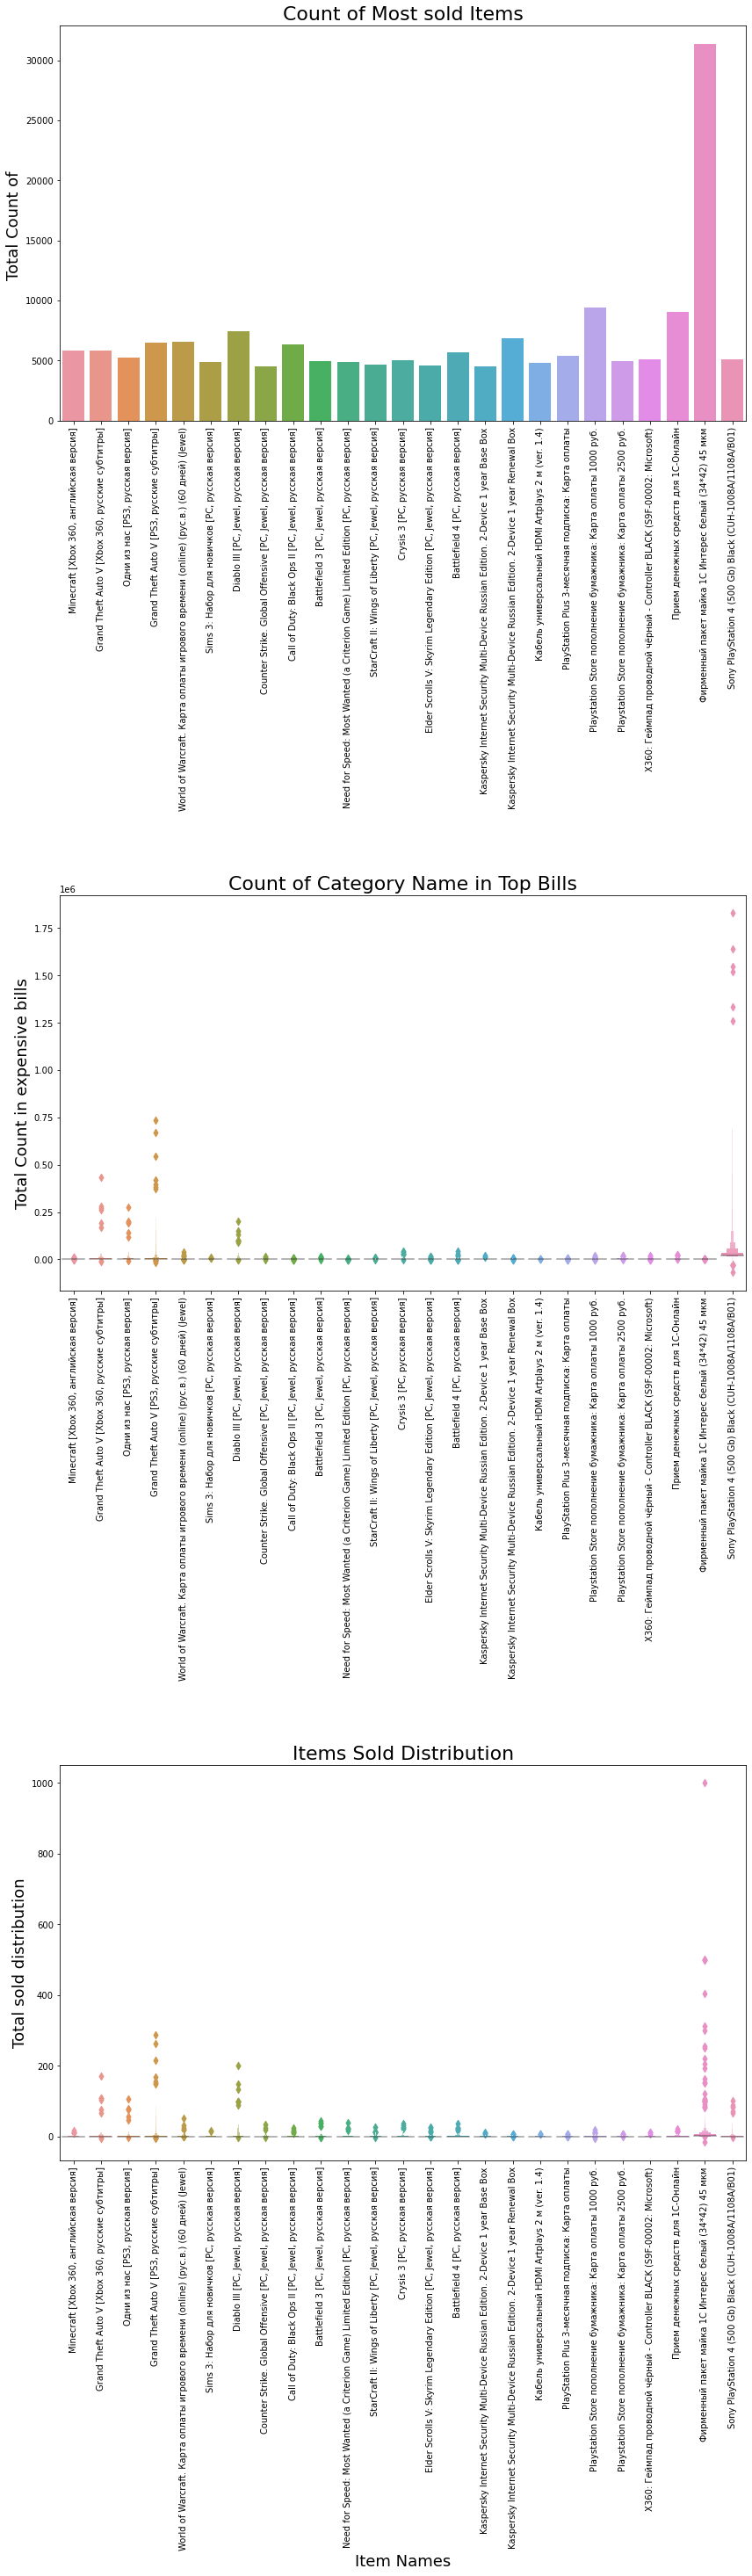

In [33]:
count_item = df_train.item_name.value_counts()[:25]

plt.figure(figsize=(14,50))

plt.subplot(311)
g = sns.countplot(x='item_name', data=df_train[df_train.item_name.isin(count_item.index)])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Most sold Items", fontsize=22)
g.set_xlabel('', fontsize=18)
g.set_ylabel("Total Count of ", fontsize=18)

plt.subplot(312)
g1 = sns.boxenplot(x='item_name', y='total_amount',
                  data=df_train[df_train.item_name.isin(count_item.index)])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
g1.set_title("Count of Category Name in Top Bills", fontsize=22)
g1.set_xlabel('', fontsize=18)
g1.set_ylabel("Total Count in expensive bills", fontsize=18)

plt.subplot(313)
g2 = sns.boxenplot(x='item_name', y='item_cnt_day', 
                  data=df_train[df_train.item_name.isin(count_item.index)])
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)
g2.set_title("Items Sold Distribution", fontsize=22)
g2.set_xlabel('Item Names', fontsize=18)
g2.set_ylabel("Total sold distribution", fontsize=18)

plt.subplots_adjust(wspace = 0.2, hspace = 1.2,top = .8)

plt.show()

#### 그래프 설명
1. 가장 많이 판매된 아이템에 대한 판매량
2. 가장 많이 판매된 아이템에 대한 총매출
3. 가장 많이 판매된 아이템에 대한 하루 판매량 분포

## 1.14 Time series

In [34]:
# Calling the function to transform the date column in datetime pandas object
df_train = date_process(df_train)

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = df_train['date'].value_counts().to_frame().reset_index().sort_values('index') 
# renaming the columns to apropriate names
dates_temp = dates_temp.rename(columns = {"date" : "Total_Bills"}).rename(columns = {"index" : "date"})

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp.date.astype(str), y=dates_temp.Total_Bills,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total tickets')

# Below we will get the total amount sold
dates_temp_sum = df_train.groupby('date')['item_price'].sum().to_frame().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.date.astype(str), line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['item_price'], opacity = 0.8)

# Getting the total values by Transactions by each date
dates_temp_count = df_train[df_train['item_cnt_day'] > 0].groupby('date')['item_cnt_day'].sum().to_frame().reset_index()

# using the new dates_temp_count we will create the third trace
trace2 = go.Scatter(x=dates_temp_count.date.astype(str), line = dict(color = color_op[5]), name="Total Items Sold",
                        y=dates_temp_count['item_cnt_day'], opacity = 0.8)

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1, trace2], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

연말에 판매량이 급증하는 것을 볼 수 있다.  
시간이 지나면서 2015년 판매량이 전체적으로 감소하는 경향이  
있는 것으로 보인다.

### 한달 단위 판매량

In [35]:


def generate_random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

#shared Xaxis parameter can make this graph look even better
fig = tls.make_subplots(rows=2, cols=1)

layout1 = cf.Layout(
    height=500,
    width=200
)
animal_color = generate_random_color()
fig1 = df_train.groupby(['_month'])['item_cnt_day'].count().iplot(kind='bar',barmode='stack',
                                                                  asFigure=True,showlegend=False,
                                                                  title='Total Items Sold By Month',
                                                                  xTitle='Months', yTitle='Total Items Sold',
                                                                  color = 'blue')
fig1['data'][0]['showlegend'] = False
fig.append_trace(fig1['data'][0], 1, 1)


fig2 = df_train.groupby(['_month'])['item_cnt_day'].sum().iplot(kind='bar',barmode='stack',
                                                                title='Total orders by Month',
                                                                xTitle='Months', yTitle='Total Orders',
                                                                asFigure=True, showlegend=False, 
                                                                color = 'blue')

#if we do not use the below line there will be two legend
fig2['data'][0]['showlegend'] = False


fig.append_trace(fig2['data'][0], 2, 1)

layout = dict(
    title= "Informations by Date",
    )

fig['layout']['height'] = 800
fig['layout']['width'] = 1000
fig['layout']['title'] = "TOTAL ORDERS AND TOTAL ITEMS BY MONTHS"
fig['layout']['yaxis']['title'] = "Total Items Sold"
fig['layout']['xaxis']['title'] = "Months"
fig['layout']

iplot(fig)

In [36]:
df_train['diff_days'] = df_train.groupby(['shop_name','item_category_name']).date.diff().dt.days.fillna(0, downcast='infer')

<AxesSubplot:>

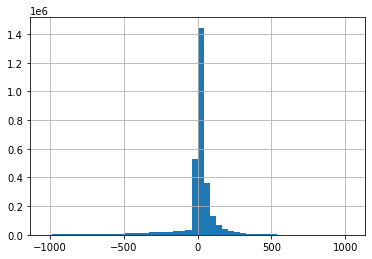

In [37]:
df_train['diff_days'].hist(bins=50)

In [38]:
grouped_blocks = df_train.groupby(["date_block_num",
                                    "shop_name","item_category_name"])["item_name",
                                                                       "item_price",
                                                                       "item_cnt_day"].agg({"item_name":["nunique", 'count'],
                                                                                            "item_price":["min",'mean','max'],
                                                                                            "item_cnt_day":["min",'mean','max','sum']})

In [39]:
grouped_blocks.head(15)

item_name  \
                                                                                  nunique   
date_block_num shop_name                        item_category_name                          
0              ! Yakutsk Ordzhonikidze, 56 fran Accessories - PS3                      16   
                                                Accessories - PS4                       1   
                                                Accessories - PSP                       5   
                                                Accessories - PSVita                   11   
                                                Accessories - XBOX 360                 10   
                                                Batteries                               3   
                                                Books - Audiobooks                     52   
                                                Books - Audiobooks 1C                  10   
                                                Books - Methodical materials 1C         4   
                                                Cinema - Blu-Ray                      209   
                                                Cinema - Blu-Ray 3D                    37   
                                                Cinema - Collection                    65   
                                                Cinema - DVD                          833   
                                                Game Consoles - PS3                     8   
                                                Game Consoles - XBOX 360                3   

                                                                                       \
                                                                                count   
date_block_num shop_name                        item_category_name                      
0              ! Yakutsk Ordzhonikidze, 56 fran Accessories - PS3                  45   
                                                Accessories - PS4                  18   
                                                Accessories - PSP                  14   
                                                Accessories - PSVita               26   
                                                Accessories - XBOX 360             55   
                                                Batteries                          12   
                                                Books - Audiobooks                 53   
                                                Books - Audiobooks 1C              13   
                                                Books - Methodical materials 1C     4   
                                                Cinema - Blu-Ray                  283   
                                                Cinema - Blu-Ray 3D                46   
                                                Cinema - Collection                87   
                                                Cinema - DVD                     1570   
                                                Game Consoles - PS3                22   
                                                Game Consoles - XBOX 360            6   

                                                                                item_price  \
                                                                                       min   
date_block_num shop_name                        item_category_name                           
0              ! Yakutsk Ordzhonikidze, 56 fran Accessories - PS3                    294.0   
                                                Accessories - PS4                    242.0   
                                                Accessories - PSP                     44.0   
                                                Accessories - PSVita                 102.0   
                                                Accessories - XBOX 360               263.0   
                                                Ba